# Relatório Técnico Projeto 01 - Análise de Imagens de Satélite
**Problema Prático 1: "Monitoramento da Degradação Florestal na Caatinga Utilizando Imagens Multiespectrais"**

Maxwell Anderson Ielpo do Amaral

### 1. Introdução

**Contextualização:**  

Este projeto tem como objetivo monitorar a degradação florestal na região da Caatinga utilizando imagens de satélite das missões Landsat 8 e Sentinel-2, e técnicas de sensoriamento remoto para calcular o Índice de Vegetação por Diferença Normalizada (NDVI). Além disso, o MapBiomas foi usado para analisar as mudanças no uso da terra e fragmentação florestal ao longo do tempo.

**Descrição do Problema:** 

A Caatinga é o bioma semiárido mais biodiverso do mundo, ocupando cerca de 11% do território brasileiro. Este bioma, no entanto, sofre com a degradação florestal, que tem impactos significativos na biodiversidade e nos modos de vida das comunidades locais. Monitorar essa degradação ao longo do tempo é crucial para a implementação de políticas de conservação e para o entendimento das dinâmicas ambientais na região.

**Objetivo Geral:** 
 
Desenvolver uma análise temporal da evolução do NDVI na Caatinga para identificar áreas de degradação florestal e quantificar as mudanças de fragmentação da vegetação utilizando métricas como o Número de Fragmentos (NP) e Índice de Fragmentação.

**Objetivos Específicos:**

1. **Aquisição de Dados**: Utilizar o Google Earth Engine para acessar e baixar imagens de satélite da missão Landsat 8 e Sentinel-2 (estudá-las!), da região da Caatinga, desde 2017.
2. **Pré-processamento**: Realizar o cálculo do *NDVI* para todas as imagens adquiridas.
3. **Análise Temporal**: Desenvolver uma análise temporal da evolução do NDVI na região, identificando áreas de possível degradação florestal ao longo do tempo.
4. **Mapeamento de Áreas Degradadas**: Utilizando imagens do MapBiomas e o  Fragstat com imagens do SLC, mapear as áreas que apresentam aumento significativo do *índice de fragmentação de floresta* durante o período estudado. Repita utilizando agora imagens da Scene Classification Layer (SCL) do Sentinel-2 para o cálculo do índice de fragmentação do Fragstat.
5. **Relatório**: Elaborar um relatório técnico que inclua todos os passos realizados, as metodologias aplicadas, os resultados obtidos e uma discussão sobre a relevância dos achados.


### 2. Metodologia e resultados

A metodologia aplicada neste estudo foi dividida em cinco etapas principais: Aquisição de Dados, Pré-processamento, Análise Temporal, Mapeamento de Áreas Degradadas, e Geração de Relatório. Cada uma dessas etapas foi implementada e executada usando o Google Earth Engine (GEE) e o Jupyter Notebook, utilizando bibliotecas como geemap, matplotlib, rasterio, e outras para o processamento e visualização dos dados. A seguir, detalhamos cada uma dessas etapas:

#### 2.1 Aquisição de dados

A aquisição dos dados foi realizada a partir do Google Earth Engine (GEE), onde foram acessadas imagens de satélite das missões Landsat 8 e Sentinel-2 para a região da Caatinga. A área de interesse (AOI) foi definida a partir de shapefiles específicos do bioma Caatinga, que foram importados e utilizados para filtrar as imagens.


In [1]:
# Realiza a importação de todas as bibliotecas necessárias para a execução do código

import ee
import geemap
import math
import time
import datetime
import os
import logging
from IPython.display import Image, HTML, display


In [2]:
# ------------------------------------------------------------------
# Funções de apoio para realização de cálculos e exibição de imagens
# ------------------------------------------------------------------


# Função para calcular a escala com base na área com redução para 10 Mp
def calculate_scale(area_m2, max_pixels=1e7):
    return math.sqrt(area_m2 / max_pixels)


# Função para realizar o download de um GIF e exibi-lo no notebook
def download_and_display_gif(file_name, visualization, gif_params):
    # Faz o download do gif
    geemap.download_ee_video(visualization, gif_params, file_name)

    # Caminho para o arquivo GIF
    gif_path = f"./{file_name}"

    # Exibe o GIF no notebook
    return Image(filename=gif_path)


# Função para exibir várias imagens lado a lado
def display_images_side_by_side(images):
    images_html = ""

    for img, legend in images:
        img_html = f"""
        <div style="display:inline-block; text-align:center; margin-right:10px;">
            <img src="{img.filename}" style="max-width:300px;">
            <p style="font-size:14px;">{legend}</p>
        </div>
        """
        images_html += img_html

    display(HTML(images_html))


def monitor_tasks(tasks):
    """Verifica o status das tarefas até que sejam concluídas."""
    while any([task.active() for task in tasks]):
        print("Aguardando conclusão das tarefas...")
        time.sleep(30)  # Verifica o status a cada 30 segundos
        for task in tasks:
            status = task.status()
            print(f"Tarefa {task.id}: {status['state']}")
    print("Todas as tarefas foram concluídas!")


In [3]:
# Inicializa o GEE
ee.Authenticate()
ee.Initialize(project="analise-satelite-projeto-01")


In [4]:
# Constantes para controle de execução

# Renderizar mapas
WITH_MAPS = True

# Processar informações extras
WITH_EXTRAS = False

# Exportar imagens para o Google Drive
WITH_DRIVE_EXPORT = False

# Define ajustes iniciais

# Define o intervalo de anos
START_YEAR = 2017
END_YEAR = 2024

# Data de início e fim para filtragem de imagens
start_date = f"{START_YEAR}-01-01"
end_date = f"{END_YEAR}-12-31"

# Porcentagem máxima de cobertura de nuvens, com o objetivo de
# reduzir a quantidade de imagens com nuvens
CLOUDY_PIXEL_PERCENTAGE = 35

# Pasta no Google Drive
FOLDER_DRIVE = "analise-satelite-projeto-01"

# Pasta de downloads local
FOLDER_DOWNLOAD = os.path.join(os.path.expanduser("."), "Downloads")

# Lista de tarefas para monitoramento
tasks = []


Importação e Filtragem das Imagens:

Para cada satélite, as coleções de imagens foram filtradas para o período entre 2017 e 2024, com uma cobertura máxima de nuvens de 35%. A área de interesse foi definida utilizando a coleção de shapefiles da Caatinga:

In [5]:
# Definir uma área de interesse (Caatinga)
# Shapefile utilizado: https://www.gov.br/insa/pt-br/centrais-de-conteudo/mapas/mapas-em-shapefile/bioma_caatinga.rar/view
caatinga_shape = ee.FeatureCollection(
    "projects/ee-maxwellamaral-proj01/assets/MAPBIOMAS/caatinga"
)

# Exporta do GEE para o pasta local
geemap.ee_to_shp(caatinga_shape, filename=f"{FOLDER_DOWNLOAD}/caatinga.shp")


In [6]:
# Define a janela de coordenadas para a região da Caatinga
caatinga_coords = caatinga_shape.geometry().coordinates()

# Define o ponto central da região da Caatinga (centroide = [long, lat])
caatinga_centroid = list(caatinga_shape.geometry().centroid().getInfo()["coordinates"])

# Obter as coordenadas da caixa delimitadora que envolve o polígono
bounding_box = caatinga_shape.geometry().bounds()

# Calcula a área da região de interesse em metros quadrados
area_m2 = caatinga_shape.geometry().area().getInfo()

# Calcula a escala com base no limite de pixels
caatinga_scale = calculate_scale(area_m2)

if WITH_EXTRAS:
    print("Coordenadas da Caatinga")
    display(caatinga_coords.getInfo()[0])
    print("Coordenadas da centróide")
    display(caatinga_centroid)
    print("Coordenadas dos limites")
    display(bounding_box.coordinates().getInfo())

display(
    f"Área da região: {area_m2:.2f} metros quadrados. Escala calculada: {caatinga_scale:.2f} metros por pixel."
)


'Área da região: 866187031049.10 metros quadrados. Escala calculada: 294.31 metros por pixel.'

#### 2.2 Pré-processamento

As imagens foram pré-processadas com o objetivo de reduzir o ruído de nuvens e ajustar a escala das bandas espectrais.

Para a coleção Landsat 8, as imagens foram importadas e ajustadas com fatores de escala para as bandas ópticas e térmicas. 

In [7]:
# ------------------------------------------------------------------
# Importação e aquisição de imagens de satélites
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# Importa a coleção de imagens do satélite LandSat 8
# ------------------------------------------------------------------

# Documentação em https://developers.google.com/earth-engine/guides/ic_creating#colab-python
# Estrutura do LandSat https://developers.google.com/earth-engine/guides/landsat#colab-python
collectionLangSat8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filterBounds(caatinga_shape)
)

bandsLandSat8RGB = ["SR_B4", "SR_B3", "SR_B2"]

# A função `apply_scale_factors(image)` é utilizada para ajustar os
# valores das bandas de uma imagem de satélite, aplicando fatores de escala.
# Isso é necessário porque os valores brutos das bandas não são diretamente
# utilizáveis para análise, já que representam dados não corrigidos.
# A aplicação desses fatores de escala converte esses valores para unidades
# mais interpretáveis, como reflectância ou temperatura de superfície.


def apply_scale_factors(image):
    # Aplica os fatores de escala para as bandas ópticas e térmicas

    # Seleciona as bandas ópticas, identificadas pelo prefixo "SR_B."
    optical_bands = image.select("SR_B.").multiply(0.0000275).add(-0.2)

    # Seleciona as bandas térmicas, identificadas pelo prefixo "ST_B.*"
    thermal_bands = image.select("ST_B.*").multiply(0.00341802).add(149.0)

    # Adiciona as bandas processadas de volta à imagem original
    # Mantém os nomes originais e substitui as bandas existentes
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)


# Aplica a função `apply_scale_factors` a cada imagem da coleção
collectionLangSat8 = collectionLangSat8.map(apply_scale_factors)

# Esta linha filtra as imagens da coleção collectionLangSat8 para manter apenas
# aquelas capturadas entre o 182º e o 243º dias do ano (entre 1º de julho e 31 de agosto).
# O propósito dessa filtragem é reduzir o tamanho da coleção de imagens,
# o que acelera o processamento.


# Adição de propriedades year e month às imagens:
# O código adiciona as propriedades year (ano) e month (mês) a cada imagem na coleção.
# Isso é feito utilizando map, onde para cada imagem (img), as propriedades year e month
# são extraídas da data da imagem e definidas como propriedades da própria imagem.

collectionLangSat8 = collectionLangSat8.map(
    lambda img: img.set("year", ee.Image(img).date().get("year"))
).map(lambda img: img.set("month", ee.Image(img).date().get("month")))

# ------------------------------------------------------------------
# Importa a coleção de imagens do satélite Sentinel 2
# ------------------------------------------------------------------

# Estrutura em https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#description
collectionSentinel = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(start_date, end_date)
    .filterBounds(caatinga_shape)
    .select("B.*|MSK_CLDPRB|SCL")
)


In [8]:
# Configurações de visualização para mapas antes do processamento

# Define os parâmetros iniciais de visualização RGB do LandSat 8
visParamsLangSat8RGB = {
    "bands": ["SR_B4", "SR_B3", "SR_B2"],
    "min": 0.0,
    "max": 0.3,
}

# Define os parâmetros iniciais de visualização para banda
# Near Infrared (NIR) do LandSat 8 com paleta de cores.
# A paleta de cores somente funciona para uma única banda.
visParamsLangSat8NIR = {
    "bands": ["SR_B5"],
    "min": 0.0,
    "max": 0.3,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}


***Características da Banda SWIR - Shortwave Infrared:***

- **Sensibilidade à Umidade**: A banda SWIR é sensível à quantidade de umidade nas plantas e no solo. Isso a torna útil para monitorar o estresse hídrico na vegetação, identificar o conteúdo de umidade do solo e detectar áreas molhadas ou secas.
- *Penetração através de Fumaça e Névoa*: a luz SWIR pode penetrar fumaça e névoa melhor do que a luz visível, tornando-a útil para a observação da superfície terrestre em condições atmosféricas adversas.
- **Detecção de Incêndios e Calor**: a banda SWIR é também sensível ao calor emitido pela superfície da Terra e pode detectar áreas quentes, como incêndios florestais, o que a torna útil para monitoramento de queimadas.
- **Discriminação de Materiais**: essa banda é útil na distinção entre diferentes materiais da superfície terrestre, como rochas, solos e vegetação. Por exemplo, minerais diferentes refletem a luz SWIR de maneiras distintas, o que facilita a análise geológica.

Na Sentinel, a Banda SWIR é útil para:

- Identificar áreas de vegetação seca ou em estresse.
- Diferenciar entre vegetação, solo exposto, e corpos d'água.
- Avaliar a presença de umidade nas plantas e solos.
- Monitorar queimadas e o impacto do fogo.

**Características da Banda NIR - Near-Infrared:**

- **Refletância Alta em Vegetação Saudável**: a banda NIR é extremamente útil para a análise da vegetação porque as plantas saudáveis refletem muito intensamente a luz nessa faixa de comprimento de onda. Essa alta refletância ocorre devido à estrutura interna das folhas, que reflete a luz NIR como um mecanismo de proteção, evitando o aquecimento excessivo.
- **Sensível ao Conteúdo de Biomassa**: A quantidade de NIR refletida por uma superfície de vegetação está diretamente relacionada ao conteúdo de biomassa verde. Vegetação mais densa e saudável reflete mais luz na banda NIR.
- **Discriminação entre Água e Terra**:A água absorve a luz NIR, o que a torna útil para distinguir corpos d'água de áreas terrestres. Superfícies aquáticas aparecem escuras em imagens NIR, enquanto áreas com vegetação ou solo refletem muito mais luz.
- **Índices de Vegetação (NDVI)**: O Índice de Vegetação da Diferença Normalizada (NDVI) é amplamente utilizado em estudos de vegetação e é calculado utilizando a refletância da banda NIR e da banda vermelha (Red). O NDVI ajuda a avaliar a saúde da vegetação, variando de valores negativos (água, por exemplo) a valores positivos (vegetação densa e saudável).

Na Sentinel é util para:

- **Monitoramento da Vegetação**: A banda NIR é amplamente utilizada para monitorar a saúde das florestas, das plantações agrícolas e da vegetação em geral. Ao combinar NIR com outras bandas (como o vermelho), é possível identificar áreas de estresse na vegetação ou zonas de desmatamento.
- **Hidrologia**: Como a água absorve fortemente a luz NIR, a banda NIR é utilizada para mapear corpos d'água e identificar inundações.
- **Índices de Vegetação**: Índices como o NDVI (Normalized Difference Vegetation Index) e o EVI (Enhanced Vegetation Index) utilizam a banda NIR em conjunto com outras bandas para fornecer medidas quantitativas da saúde e da cobertura de vegetação.
- **Monitoramento de Desmatamento e Degradação**: Alterações no uso da terra, como desmatamento ou degradação ambiental, podem ser detectadas ao observar a mudança na refletância da banda NIR ao longo do tempo.


In [9]:

# Define os parâmetros iniciais de visualização RGB do Sentinel 2

visParamsSentinelRGB = {
    # Banda B11 (SWIR), B8 (NIR) e B3 (Green)
    "bands": ["B11", "B8", "B3"],
    "min": 0,
    "max": 4000,
}

# Define os parâmetros iniciais de visualização para banda
# Near Infrared (NIR) do Sentinel 2 com paleta de cores.
# A paleta de cores somente funciona para uma única banda.
visParamsSentinelNIR = {
    "bands": ["B8"],
    "min": 0,
    "max": 4000,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}


In [10]:
# Centróide da região da Caatinga
# ? Por algum motivo as coordenadas da centróide estão invertidas.
# ? Por isto, estou usando invertendo usando [::-1]
centroid = caatinga_centroid[::-1]

# Para visualização do mapa, deve-se pegar uma imagem da coleção, podendo ser
# a primeira `.first()`, média `mean()` ou a mediana das imagens `.median()`. Depois faz-se o
# `clip(máscara)`
# imageLangSat8Clip = collectionLangSat8.median().clip(caatinga_shape)

# Reduz temporariamente as datas para 2021
# collectionLangSat8 = collectionLangSat8.filterDate('2021-01-01', '2021-12-31')
# collectionSentinel = collectionSentinel.filterDate('2021-01-01', '2021-12-31')

# Filtra a coleção de imagens com redução de cobertura de nuvens e com recorte para a região da Caatinga
# ! Não funcionam efetivamente para redução de nuvens nestes satélites a 35%
# collectionLangSat8Cloud = collectionLangSat8.filter(
#     ee.Filter.eq("CLOUD_COVER_LAND", CLOUDY_PIXEL_PERCENTAGE)
# )
# collectionSentinel2Cloud = collectionSentinel.filter(
#     ee.Filter.eq("CLOUDY_PIXEL_PERCENTAGE", CLOUDY_PIXEL_PERCENTAGE)
# )


In [11]:
# Adiciona as camadas ao mapa
# ! Cerca de 8 minutos para exibição inicial do mapa como coleção completa.
# ! Desta forma preferiu-se realizar a exibição de uma imagem médiana da coleção.

# Usar a média das imagens e o recorte da Caatinga para exibição.
# Isto também diminui o tempo de processamento do lado cliente, embora não se tenha acesso à coleção completa.
imageLangSat8Clip = collectionLangSat8.mean().clip(caatinga_shape)


In [12]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [13]:
# Aplicando camadas extras ao mapa acima
Map.centerObject(caatinga_shape, 6)
Map.addLayer(imageLangSat8Clip, visParamsLangSat8RGB, "LandSat 8 RGB")


In [14]:
region = bounding_box
fc = ee.FeatureCollection(region)
style = {"color": "ffff00ff", "fillColor": "00000000"}
Map.add_layer(fc.style(**style), {}, "ROI")


In [15]:
# Usar a média das imagens e o recorte da Caatinga para exibição.
# Isto também diminui o tempo de processamento do lado cliente, embora não se tenha acesso à coleção completa.
collectionSentinelClip = collectionSentinel.mean().clip(caatinga_shape)


In [16]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.centerObject(caatinga_shape, 6)
Map.addLayer(
    collectionSentinelClip, visParamsSentinelRGB, "Sentinel RGB", True
)
Map


Map(center=[-9.14194749192333, -40.33879812854873], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
# ------------------------------------------------------------------
# Exportação das imagens para o Google Drive e download das imagens
# ------------------------------------------------------------------

import calendar

if WITH_DRIVE_EXPORT:
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            last_day = calendar.monthrange(year, month)[1]

            # Definindo as datas de início e fim do mês
            start_date = datetime.datetime(year, month, 1)
            end_date = datetime.datetime(year, month, last_day)

            start_date_str = start_date.strftime("%Y-%m-%d")
            end_date_str = end_date.strftime("%Y-%m-%d")

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

            # -------------------------------------------
            # Landsat 8 - Exportação de uma imagem por mês
            # -------------------------------------------
            try:
                collectionLandSat8Export = (
                    collectionLangSat8.select(["SR_B5", "SR_B4"])
                    .filterDate(start_date_str, end_date_str)
                    .filter(ee.Filter.lt("CLOUD_COVER_LAND", CLOUDY_PIXEL_PERCENTAGE))
                )

                collection_count = collectionLandSat8Export.size().getInfo()
                print(
                    f"Total de imagens do LandSat 8 para o mês {month} de {year}: {collection_count}"
                )

                if collection_count == 0:
                    print(f"Não há imagens do Landsat 8 para o mês {month} de {year}.")
                else:
                    # Exporta a imagem para o Google Drive
                    landsat_task = ee.batch.Export.image.toDrive(
                        image=collectionLandSat8Export.median().clip(caatinga_shape),
                        description=f"Landsat_ExportProject_{year}_{month}_{timestamp}",
                        folder=FOLDER_DRIVE,
                        scale=caatinga_scale,
                        region=caatinga_shape.geometry()
                        .bounds()
                        .getInfo()["coordinates"],
                        fileFormat="GeoTIFF",
                    )

                    landsat_task.start()
                    tasks.append(landsat_task)

            except Exception as e:
                print(
                    f"Ocorreu um erro durante a exportação do Landsat 8 para {year}-{month}: {e}"
                )

            # -------------------------------------------
            # Sentinel-2 - Exportação de uma imagem por mês
            # -------------------------------------------

            try:
                collectionSentinelExport = (
                    collectionSentinel.select(["B8", "B4"])
                    .filterDate(start_date_str, end_date_str)
                    .filter(
                        ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", CLOUDY_PIXEL_PERCENTAGE)
                    )
                    .filter(ee.Filter.lt("CLOUD_SHADOW_PERCENTAGE", 10))
                )

                collection_count = collectionSentinelExport.size().getInfo()
                print(
                    f"Total de imagens do Sentinel 2 para o mês {month} de {year}: {collection_count}"
                )

                if collection_count == 0:
                    print(f"Não há imagens do Sentinel 2 para o mês {month} de {year}.")
                else:
                    # Exporta a imagem para o Google Drive
                    sentinel_task = ee.batch.Export.image.toDrive(
                        image=collectionSentinelExport.median().clip(caatinga_shape),
                        description=f"Sentinel_Export_{year}_{month}_{timestamp}",
                        folder=FOLDER_DRIVE,
                        scale=caatinga_scale,
                        region=caatinga_shape.geometry()
                        .bounds()
                        .getInfo()["coordinates"],
                        fileFormat="GeoTIFF",
                    )

                    sentinel_task.start()
                    tasks.append(sentinel_task)
            except Exception as e:
                print(
                    f"Ocorreu um erro durante a exportação do Sentinel 2 para {year}-{month}: {e}"
                )


Conforme Google(2024):

"A vegetação reflete a luz na parte do infravermelho próximo (NIR) do espectro eletromagnético e absorve a luz na parte vermelha. O NDVI usa isso para criar um único valor que reflete aproximadamente a atividade fotossintética que ocorre em um pixel. O cálculo é (NIR - vermelho) / (NIR + vermelho). Isso resulta em um número entre 1 e -1, onde pixels com alta atividade fotossintética têm um NDVI alto." (ver https://developers.google.com/earth-engine/tutorials/tutorial_api_06 e https://science.nasa.gov/ems/08_nearinfraredwaves)
 
Para o cálculo do NDVI, foram utilizadas as bandas vermelha (Red) e infravermelha próxima (NIR). Os arquivos foram processados para diferentes períodos, de acordo com os satélites (Landsat e Sentinel).

O NDVI é calculado utilizando a fórmula:

$$
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
$$

O NDVI foi processado individualmente para cada imagem adquirida, resultando em um conjunto de imagens temporais que representam a vegetação na Caatinga ao longo do período de estudo.

NO GEE, a função `normalizedDifference` calcula a diferença normalizada entre duas bandas de uma imagem da seguinte forma:

```python
nir_band = image.select('B5');
red_band = image.select('B4');
ndvi_band = nir_band.subtract(red_band).divide(nir_band.add(red_band)).rename('NDVI')
``` 


In [18]:
# Exemplo de processamento de imagens para NDVI com uso do GEE
def addNDVI(image, nir_band, red_band):
    ndvi = image.normalizedDifference([nir_band, red_band]).rename("NDVI")
    return image.addBands(ndvi)


# ------------------------------------------------------------------
# Processamento para LandSat 8
# ------------------------------------------------------------------

# Seleção das bandas NIR e Red com filtro de nuvens sobre a terra (exclui águas)
collectionLandSat8withoutNDVI = (
    collectionLangSat8.select(["SR_B5", "SR_B4"])
    .filter(ee.Filter.lt("CLOUD_COVER_LAND", CLOUDY_PIXEL_PERCENTAGE))
    .sort("CLOUD_COVER_LAND")
)
# Teste sobre imagem única
# ndvi = addNDVI(image, "SR_B5", "SR_B4").select("NDVI")

# Aplica a função addNDVI a cada imagem da coleção
collectionLandSat8withNDVI = collectionLandSat8withoutNDVI.map(
    lambda img: addNDVI(img, "SR_B5", "SR_B4")
)

# ------------------------------------------------------------------
# Processamento para Sentinel 2
# ------------------------------------------------------------------

# Seleção das bandas NIR e Red com filtro de nuvens e sombra de nuvem abaixo de 10%
collectionSentinel2withoutNDVI = (
    collectionSentinel.select(["B8", "B4"])
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", CLOUDY_PIXEL_PERCENTAGE))
    .filter(ee.Filter.lt("CLOUD_SHADOW_PERCENTAGE", 10))
    .sort("CLOUDY_PIXEL_PERCENTAGE")
)

# Aplica a função addNDVI a cada imagem da coleção
collectionSentinel2withNDVI = collectionSentinel2withoutNDVI.map(
    lambda img: addNDVI(img, "B8", "B4")
)


In [19]:
# ------------------------------------------------------------------
# Exemplo de visualização do NDVI
# ------------------------------------------------------------------

visNDVI = {
    "bands": "NDVI",
    "min": -1,
    "max": 1,
    "palette": ["blue", "white", "green"],
}

visNDVIgreenest = {
    "bands": ["NDVI"],
    "max": 0.3,
    "palette": ["blue", "white", "green"],
}


Mapa de NDVI para o Período 2017-2024:

O mapa abaixo exibe a média do NDVI calculado a partir das imagens de satélite entre 2017 e 2024. A paleta de cores vai do azul (baixos valores de NDVI) ao verde (altos valores de NDVI), refletindo a densidade da vegetação.

In [20]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.centerObject(caatinga_shape, 6)
Map.addLayer(
    collectionLandSat8withNDVI.mean().clip(caatinga_shape),
    visNDVI,
    "NDVI LandSat",
)
Map


Map(center=[-9.14194749192333, -40.33879812854873], controls=(WidgetControl(options=['position', 'transparent_…

Interpretação: As áreas com NDVI mais elevado (em verde) indicam regiões de vegetação mais densa e saudável, enquanto as áreas com NDVI mais baixo (em branco) podem indicar degradação, menor densidade vegetal, ou outros tipos de cobertura do solo, como solo exposto.

Acima: NDVI calculado via Landsat 8

In [21]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.centerObject(caatinga_shape, 6)
Map.addLayer(
    collectionSentinel2withNDVI.mean().clip(caatinga_shape),
    visNDVI,
    "NDVI Sentinel via GEE",
    True,
)
Map


Map(center=[-9.14194749192333, -40.33879812854873], controls=(WidgetControl(options=['position', 'transparent_…

Acima: NDVI calculado via Sentinel 2

#### 2.3 Análise Temporal

Para a análise temporal, a evolução do NDVI médio foi monitorada ao longo dos anos.

Para criar um gráfico que demonstre a relação entre o NDVI e o período de tempo (com intervalos mensais entre 2017 e 2024) para as coleções de imagens dos satélites, foi necessário calcular as médias mensais de NDVI para o período entre 2017 e 2024. O gráfico de linhas delineia o eixo X que representa o tempo (com intervalos mensais) e o eixo Y que representa o valor médio do NDVI.

In [22]:
# Calcula a área da região de interesse em metros quadrados
area_m2 = caatinga_shape.geometry().area().getInfo()
display(f"Área da região: {area_m2:,.2f} metros quadrados.")


'Área da região: 866,187,031,049.10 metros quadrados.'

**Análise com coleção MODIS**

A escolha da coleção MODIS se mostrou mais eficaz para a determinação do NDVI, se comparados com as outras coleções. Apesar de existir versões com resolução de 250 m/px, por necessidade de processamento eficaz em menor tempo, utilizou-se para este experimento coleção com resolução de 1000 m/px, entre os anos 2000 e 2020 na geração de mapa.

In [23]:
forest = caatinga_shape

veg_indices = (
    ee.ImageCollection("MODIS/061/MOD13A1")
    .filter(ee.Filter.date("2000-01-01", "2020-01-01"))
    .select(["NDVI"])
)


In [24]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.centerObject(caatinga_shape, 6)
Map.addLayer(
    veg_indices.mean().clip(caatinga_shape),
    {},
    "NDVI",
    True,
)
Map


Map(center=[-9.14194749192333, -40.33879812854873], controls=(WidgetControl(options=['position', 'transparent_…

**Agregação e Visualização dos Dados:**

Para calcular as médias mensais do NDVI, os dados foram agregados e visualizados usando matplotlib, neste caso, dados entre 2017 e 2024.

A análise temporal do NDVI foi realizada para monitorar a evolução da vegetação na região da Caatinga ao longo dos anos. Foram calculadas as médias mensais do NDVI, e os dados foram visualizados em gráficos que demonstram as tendências de variação da vegetação.

In [25]:
import matplotlib.pyplot as plt
import pandas as pd


# Calcula a área da região de interesse em metros quadrados
area_m2 = caatinga_shape.geometry().area().getInfo()
display(f"Área da região: {area_m2:,.2f} metros quadrados.")

# Carrega os dados de índices de vegetação MODIS e seleciona os anos de 2017 a 2024.
collection = (
    ee.ImageCollection("MODIS/006/MOD13A1")
    .filter(ee.Filter.date(start_date, end_date))
    .select(["NDVI"])
)


# Reduz a coleção de imagens para a região da pastagem e calcula a média por mês.
def reduce_region(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=caatinga_shape.geometry(), scale=500
    )
    return image.set(
        {"NDVI": stats.get("NDVI"), "system:time_start": image.get("system:time_start")}
    )


# Aplica a função de redução a cada imagem na coleção.
reduced_vegIndices = collection.map(reduce_region)

# Converte a coleção de imagens reduzida para listas separadas de tempo e NDVI.
dates_list = reduced_vegIndices.aggregate_array("system:time_start").getInfo()
ndvi_list = reduced_vegIndices.aggregate_array("NDVI").getInfo()

# Extrai os valores de tempo e NDVI.
dates = [
    pd.to_datetime(ee.Date(item).format("YYYY-MM-dd").getInfo()) for item in dates_list
]
ndvi_values = ndvi_list

# Cria um DataFrame para facilitar a manipulação dos dados.
df = pd.DataFrame({"Date": dates, "NDVI": ndvi_values})

# Adiciona colunas com o mês e o ano correspondente.
df["Month"] = df["Date"].dt.to_period("M")

# Agrupa os dados por mês e calcula a média dos valores de NDVI.
df_grouped = df.groupby("Month").mean().reset_index()


'Área da região: 866,187,031,049.10 metros quadrados.'

**Gráfico de NDVI Médio Mensal (2017-2024):**

O gráfico abaixo mostra a evolução do NDVI médio na Caatinga ao longo do período de 2017 a 2024. As médias mensais foram calculadas a partir das imagens de satélite do Landsat 8 e Sentinel-2. O eixo X representa o tempo (meses), enquanto o eixo Y representa os valores médios do NDVI.

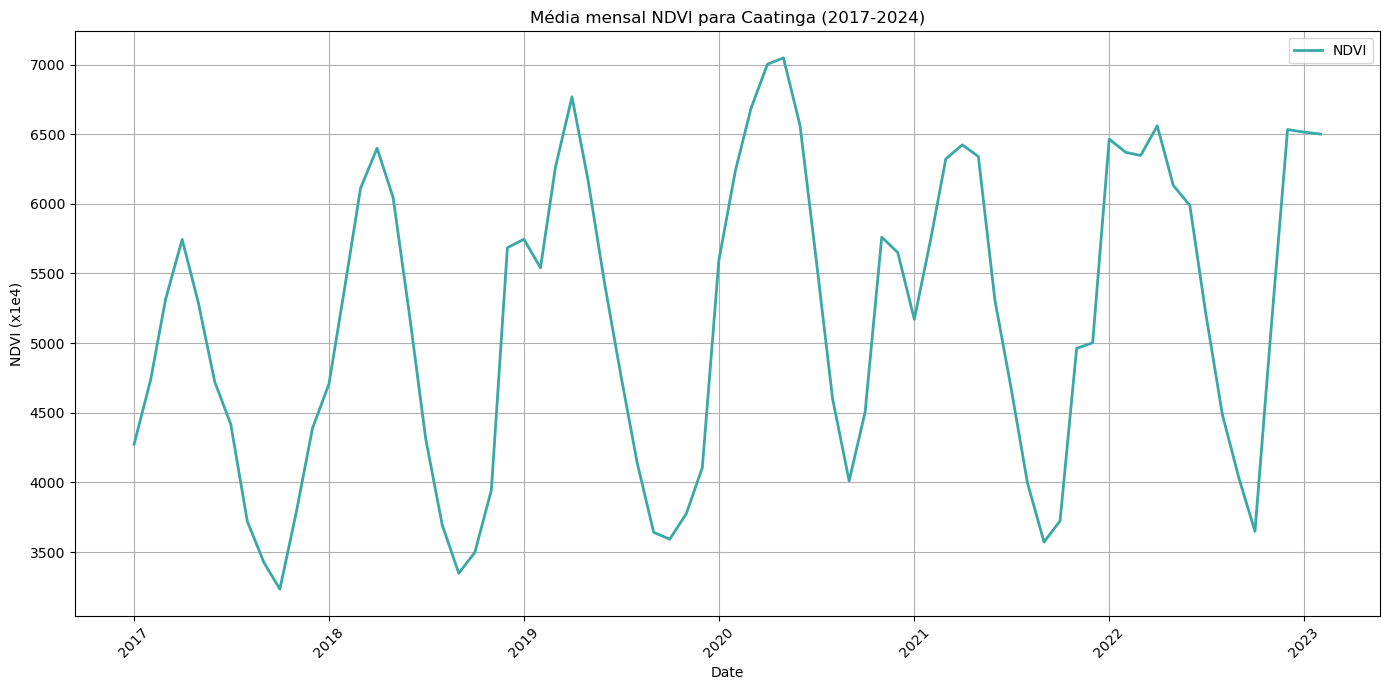

In [26]:

# Plota os dados agregados por mês usando Matplotlib.
plt.figure(figsize=(14, 7))
plt.plot(
    df_grouped["Month"].dt.to_timestamp(),
    df_grouped["NDVI"],
    label="NDVI",
    color="#39a8a7",
    linewidth=2,
)
plt.title("Média mensal NDVI para Caatinga (2017-2024)")
plt.xlabel("Date")
plt.ylabel("NDVI (x1e4)")
plt.xticks(rotation=45)  # Rotaciona os ticks do eixo X para melhorar a legibilidade
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretação: O gráfico revela uma variação sazonal clara no NDVI, com picos durante os períodos de chuva e declínios durante os períodos de seca. Esse padrão é consistente com o comportamento da vegetação em regiões semiáridas, onde a disponibilidade de água é o principal fator limitante para o crescimento das plantas.

In [27]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [28]:
Map.addLayer(reduced_vegIndices.mean().clip(caatinga_shape), {'bands': 'NDVI'}, "LandSat NDVI")

Map.centerObject(caatinga_shape, 6)

fc = ee.FeatureCollection(bounding_box)
style = {"color": "ffff00ff", "fillColor": "00000000"}
Map.add_layer(fc.style(**style), {}, "ROI")


In [29]:
# Gerando um timelapse utilizando a função landsat_timelapse

filename = "caatinga"
year = 2000
while year < 2024:
    timelapse = geemap.landsat_timelapse(
        region,
        out_gif=f'{filename}_{year}.gif',
        start_year=year,
        end_year=year,
        start_date="06-01",
        end_date="09-01",
        bands=["SWIR1", "NIR", "Red"],
        frames_per_second=5,
        title="Landsat Timelapse",
        progress_bar_color="blue",
        dimensions=500,
        fading=True,
    )
    year+=1


Generating URL...
Please wait ...
The GIF image has been saved to: x:\10-19-projetos\11-work\11.32-doutorado\AIS\AIS-01\caatinga_2000.gif
[WinError 32] O arquivo já está sendo usado por outro processo: 'C:\\Users\\max\\AppData\\Local\\Temp\\caatinga_2000'
Generating URL...
Please wait ...
The GIF image has been saved to: x:\10-19-projetos\11-work\11.32-doutorado\AIS\AIS-01\caatinga_2001.gif
[WinError 32] O arquivo já está sendo usado por outro processo: 'C:\\Users\\max\\AppData\\Local\\Temp\\caatinga_2001'
Generating URL...
Please wait ...
The GIF image has been saved to: x:\10-19-projetos\11-work\11.32-doutorado\AIS\AIS-01\caatinga_2002.gif
[WinError 32] O arquivo já está sendo usado por outro processo: 'C:\\Users\\max\\AppData\\Local\\Temp\\caatinga_2002'
Generating URL...
Please wait ...
The GIF image has been saved to: x:\10-19-projetos\11-work\11.32-doutorado\AIS\AIS-01\caatinga_2003.gif
[WinError 32] O arquivo já está sendo usado por outro processo: 'C:\\Users\\max\\AppData\\Loca

In [30]:
from PIL import Image
import os

# Definir o intervalo de anos
anos = range(2000, 2024)

# Inicializar uma lista para armazenar as imagens
imagens = []

# Carregar todas as imagens e adicionar à lista
for year in anos:
    filename = f'caatinga_{year}.gif'
    if os.path.exists(filename):
        imagem = Image.open(filename)
        imagens.append(imagem)

# Verificar se há imagens para combinar
if imagens:
    # Salvar todas as imagens em uma única animação GIF sequencial
    imagens[0].save(
        'caatinga_combined.gif',
        save_all=True,
        append_images=imagens[1:],
        duration=500,  # Duração de cada frame em milissegundos
        loop=0  # Loop infinito
    )
else:
    print("Nenhuma imagem encontrada para combinar.")


In [31]:
# Abrir o arquivo
geemap.show_image('caatinga_combined.gif')


Output()


#### 2.4 Mapeamento de Áreas Degradadas

O mapeamento das áreas degradadas foi realizado utilizando os dados do MapBiomas e o GEE com Geemap para calcular métricas de fragmentação florestal. Essas métricas permitiram identificar regiões onde houve um aumento significativo da fragmentação ao longo do tempo.

Foram utilizadas as imagens do MapBiomas para identificar e quantificar as áreas com degradação significativa. As imagens foram processadas para identificar e quantificar as áreas com degradação significativa, considerando um limiar de NDVI onde o valor caiu abaixo de -0,1:

In [32]:
# Configurar o logger
log_file = './data/mapbiomas/feature_collection_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Definir a coleção do MapBiomas Coleção 8 para deforestation_regeneration
mapbiomas_deforestation = ee.Image(
    'projects/mapbiomas-workspace/public/collection8/mapbiomas_collection80_deforestation_secondary_vegetation_v2'
)

# Filtrar para o bioma Caatinga
caatinga_biome = ee.FeatureCollection(
    "projects/mapbiomas-workspace/AUXILIAR/ESTATISTICAS/COLECAO8/VERSAO-1/refined_biome"
).filter(ee.Filter.eq("NAME_PT_BR", "Caatinga"))

# Obter uma lista de todas as propriedades disponíveis na FeatureCollection
first_feature = caatinga_biome.first()
properties = first_feature.propertyNames().getInfo()

# Registrar a lista de propriedades
logger.info("Propriedades disponíveis na FeatureCollection:")
for property in properties:
    logger.info(property)


In [33]:
# Filtrar a coleção para exibir desmatamento e regeneração na Caatinga
deforestation_regeneration = mapbiomas_deforestation.clip(caatinga_biome)

# Configurações de visualização
vis_params = {
    # "bands": ["classification_2001"],
    "min": 0,
    "max": 7,
    # "format": "png",
    "palette": [
        "#212121",  # [0] Outros
        "#fffbc2",  # [1] Antrópico
        "#09611f",  # [2] Vegetação primária
        "#4ea376",  # [3] Vegetação secundária
        "#e31a1c",  # [4] Antropismo em vegetação primária
        "#94fc03",  # [5] Recuperação para veg secundaria
        "#ffa500",  # [6] Antropismo em vegetação secundária
        "#212121",  # [7] Não se aplica
    ],
}


In [34]:

# Cria o mapa e adiciona a camada
map = geemap.Map()
map.centerObject(caatinga_biome, 5)
map.add_basemap("HYBRID")
# map.addLayer(
#     deforestation_regeneration.divide(100).byte(),
#     vis_params,
#     "Deforestation & Regeneration in Caatinga",
# )

# Exibe o mapa
map


Map(center=[-9.14194650340123, -40.338798359365825], controls=(WidgetControl(options=['position', 'transparent…

In [44]:
# Adicionar as camadas de cada ano ao mapa
for year in range(1986, 2022):
    band_name = f"classification_{year}"
    map.addLayer(
        deforestation_regeneration.select(band_name).divide(100).byte(),
        vis_params,
        f"{year}_RGB",
        False,
    )
    
    map.addLayer(
        deforestation_regeneration.select(band_name).divide(100).byte(),
        {'min': 0, 'max': 7},
        f"{year}",
        False,
    )    
    
    if WITH_DRIVE_EXPORT:
    # if True:
        map.layer_to_image(
            f"{year}_RGB",
            output=f"./data/mapbiomas/mapbiomas_{year}_RGB.tif",
            scale=300, # Nesta escala, o arquivo é reduzido de 5GB para 58MB
            crs="EPSG:3857",
            region=bounding_box,
        )
        
        
        map.layer_to_image(
            f"{year}",
            output=f"./data/mapbiomas/mapbiomas_{year}.tif",
            scale=300, # Nesta escala, o arquivo é reduzido de 5GB para 58MB
            region=bounding_box,
        )


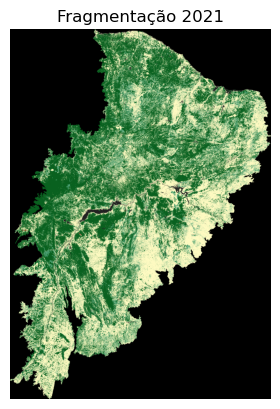

In [36]:
import os
import rasterio
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def load_geotiff_images(image_folder, pattern):
    """Carrega imagens GeoTIFF de uma pasta com base em um padrão de nome de arquivo."""
    image_files = sorted([f for f in os.listdir(image_folder) if pattern in f and f.endswith('_RGB.tif')])
    images = []
    for img_file in image_files:
        with rasterio.open(os.path.join(image_folder, img_file)) as src:
            images.append(src.read([1, 2, 3]))  # Carregar as três bandas RGB
    return images, image_files

def create_animation(images, image_files, output_file):
    """Cria uma animação a partir das imagens carregadas."""
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        ax.imshow(images[frame].transpose(1, 2, 0))  # Transpor para (altura, largura, canais)
        ax.set_title(f'Fragmentação {image_files[frame].split("_")[1]}')
        ax.axis('off')

    ani = animation.FuncAnimation(fig, update, frames=len(images), repeat=True)
    ani.save(output_file, writer='imagemagick', fps=1)
    plt.show()

# Definir a pasta de imagens e o padrão de nome de arquivo
image_folder = './data/mapbiomas'
pattern = 'mapbiomas_'
output_file = './data/mapbiomas/fragmentacao_animation.gif'

# Carregar as imagens GeoTIFF
images, image_files = load_geotiff_images(image_folder, pattern)

# Criar a animação
create_animation(images, image_files, output_file)


Acima: animação dos mapas de fragmentação de 1986 a 2022

**Mapa de Fragmentação Florestal:**

A seguir, é apresentado um mapa que ilustra a fragmentação florestal na Caatinga em dois períodos distintos: 1986 e 2021. As imagens foram processadas para destacar as áreas onde houve um aumento significativo na fragmentação ao longo desses anos.

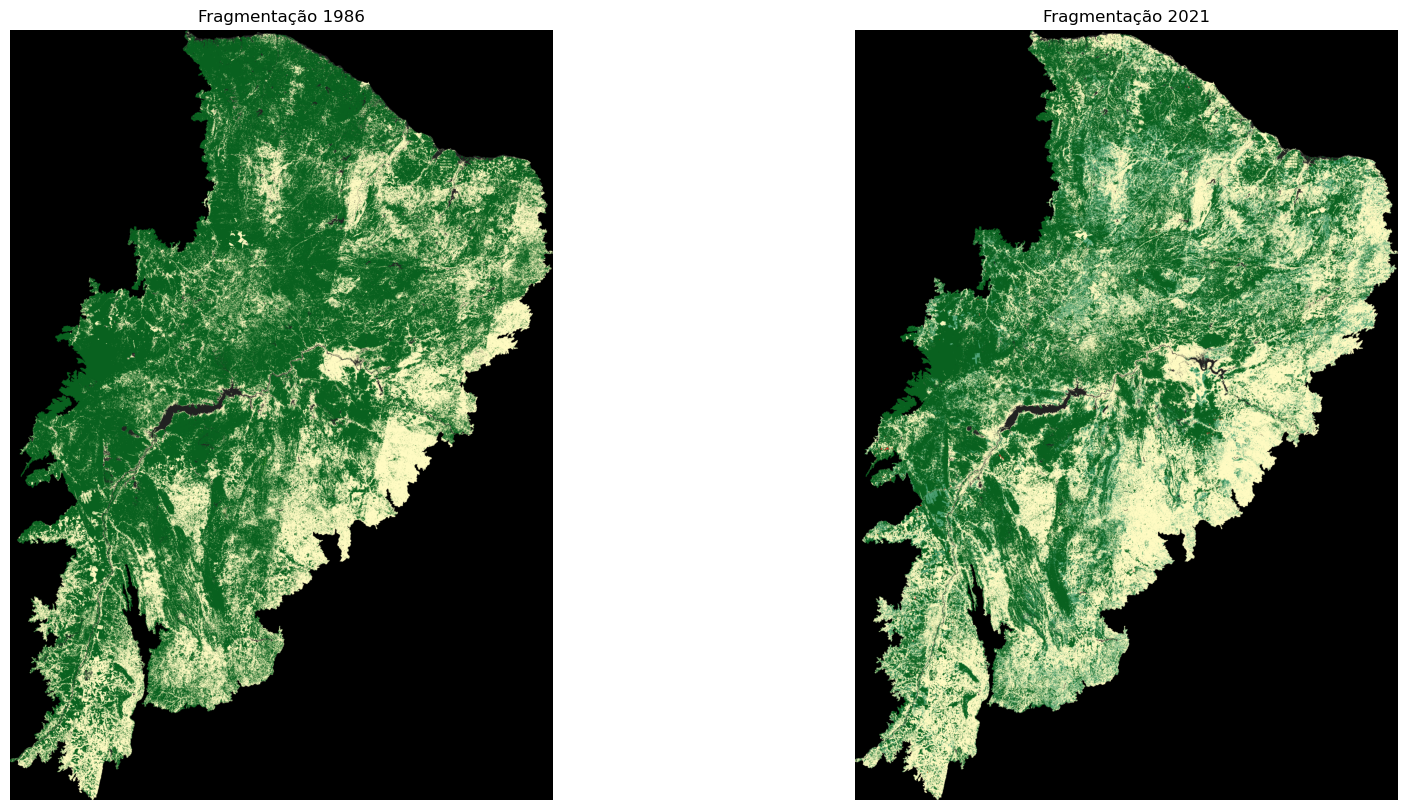

In [37]:
import os
import rasterio
import matplotlib.pyplot as plt

def load_geotiff_image(image_path):
    """Carrega uma imagem GeoTIFF de um caminho específico."""
    with rasterio.open(image_path) as src:
        return src.read([1, 2, 3])  # Carregar as três bandas RGB

# Definir a pasta de imagens e os nomes dos arquivos
image_folder = './data/mapbiomas'
image_1986 = os.path.join(image_folder, 'mapbiomas_1986_RGB.tif')
image_2021 = os.path.join(image_folder, 'mapbiomas_2021_RGB.tif')

# Carregar as imagens GeoTIFF dos anos 1986 e 2021
img_1986 = load_geotiff_image(image_1986)
img_2021 = load_geotiff_image(image_2021)

# Exibir as imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img_1986.transpose(1, 2, 0))  # Transpor para (altura, largura, canais)
axes[0].set_title('Fragmentação 1986')
axes[0].axis('off')

axes[1].imshow(img_2021.transpose(1, 2, 0))  # Transpor para (altura, largura, canais)
axes[1].set_title('Fragmentação 2021')
axes[1].axis('off')

plt.show()


Interpretação: O aumento no número de fragmentos (patches) e na densidade de borda entre 1986 e 2021 é evidente. As áreas identificadas como fragmentadas são indicativas de degradação florestal, o que pode ter sérios impactos na biodiversidade e nos ecossistemas locais.

In [38]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import label
import logging

# Configurar o logger
log_file = './data/mapbiomas/fragmentacao/fragmentation_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Definir o caminho da pasta onde os arquivos MapBiomas estão armazenados
data_dir = "./data/mapbiomas"

# Inicializar uma lista para armazenar os nomes dos arquivos
map_files = []

# Padrão regex para verificar os arquivos
default = re.compile(r'mapbiomas_(\d{4}).tif')

# Iterar sobre todos os arquivos na pasta
for filename in os.listdir(data_dir):
    if default.match(filename):
        year = int(default.match(filename).group(1))
        if 1986 <= year <= 2021:
            map_files.append(filename)

# Registrar a lista de nomes de arquivos
logger.info("Nomes dos arquivos encontrados:")
for name in map_files:
    logger.info(name)


In [39]:
import os
import pandas as pd
import numpy as np
import rasterio
from scipy.ndimage import label
import logging

# Configurar o logger
log_file = './data/mapbiomas/fragmentacao/fragmentation_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Dicionário para armazenar os resultados de fragmentação ao longo do tempo
fragmentation_metrics = {}
fragmentation_metrics_table = []

# Definir a resolução espacial do raster (tamanho do pixel em metros)
pixel_size = 300  # Exemplo: 300 metros por pixel

# Iterar pelos arquivos de diferentes anos
for map_file in map_files:
    # Nome do ano para os dados
    year = map_file.split("_")[1]

    # Construir o caminho completo do arquivo
    file_path = os.path.join(data_dir, map_file)

    # Carregar o raster para verificar as classes presentes
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)  # Lê a primeira banda do raster
        classes_present = np.unique(raster_data)  # Obter classes únicas presentes no raster
        logger.info(f"Classes presentes em {year}: {classes_present}")

    # Definir a classe de interesse
    class_value = 73

    if class_value in classes_present:
        # Criar uma máscara binária para a classe de interesse
        class_mask = raster_data == class_value

        # Contar o número de fragmentos (patches) usando a função label
        labeled_array, num_patches = label(class_mask)

        # Calcular a área total da classe (em pixels)
        total_area_pixels = np.sum(class_mask)

        if total_area_pixels > 0:
            # Calcular a área total da classe em metros quadrados
            total_area_m2 = total_area_pixels * (pixel_size**2)

            # Calcular a porcentagem de fragmentação
            fragmentation_percentage = (num_patches / total_area_pixels) * 100

            # Armazenar os resultados no dicionário
            fragmentation_metrics[year] = {
                "number_of_patches": num_patches,
                "total_area_pixels": total_area_pixels,
                "total_area_m2": total_area_m2,
                "fragmentation_percentage": fragmentation_percentage,
            }
            
            fragmentation_metrics_table.append({
                "Ano": year[:4],
                "Número de áreas fragmentadas": num_patches,
                # "Área total (px)": total_area_pixels,
                # "Área total (m²)": abs(total_area_m2),
                "Porcentagem de fragmentação": fragmentation_percentage,
            })

            logger.info(f"Métricas de Fragmentação para {year}:")
            logger.info(f"Número de áreas fragmentadas: {num_patches:,.0f}")
            logger.info(f"Área total (px): {total_area_pixels:,.0f} pixels")
            logger.info(f"Área total (m²): {abs(total_area_m2):,.0f} m²")
            logger.info(f"Porcentagem de fragmentação: {fragmentation_percentage:.2f}%")
        else:
            logger.info(f"A classe {class_value} não está presente no arquivo {map_file}")


**Tabela de Métricas de Fragmentação:**

A tabela abaixo resume as principais métricas de fragmentação florestal para o período de 1986 a 2021. As métricas foram calculadas utilizando o pylandstats e outros métodos de análise de imagem.

In [40]:

# Criar um DataFrame a partir da lista de resultados
df = pd.DataFrame(fragmentation_metrics_table)

# Definir a formatação das colunas do DataFrame para exibir casas decimais
# df["Área total (px)"] = df["Área total (px)"].map('{:,.0f}'.format)
# df["Área total (m²)"] = df["Área total (m²)"].map('{:,.0f}'.format)
df["Porcentagem de fragmentação"] = df["Porcentagem de fragmentação"].map('{:.2f}%'.format)

# Exibir o DataFrame como uma tabela Markdown
from IPython.display import display, Markdown
display(Markdown(df.to_markdown(index=False)))


|   Ano |   Número de áreas fragmentadas | Porcentagem de fragmentação   |
|------:|-------------------------------:|:------------------------------|
|  1986 |                         128682 | 1.96%                         |
|  1987 |                         130377 | 2.02%                         |
|  1988 |                         134319 | 2.13%                         |
|  1989 |                         139558 | 2.27%                         |
|  1990 |                         143678 | 2.39%                         |
|  1991 |                         146766 | 2.49%                         |
|  1992 |                         148942 | 2.57%                         |
|  1993 |                         151407 | 2.65%                         |
|  1994 |                         153681 | 2.73%                         |
|  1995 |                         155777 | 2.80%                         |
|  1996 |                         157951 | 2.88%                         |
|  1997 |                         159700 | 2.94%                         |
|  1998 |                         161355 | 3.00%                         |
|  1999 |                         163437 | 3.08%                         |
|  2000 |                         165021 | 3.14%                         |
|  2001 |                         166516 | 3.22%                         |
|  2002 |                         167956 | 3.28%                         |
|  2003 |                         169415 | 3.35%                         |
|  2004 |                         170957 | 3.43%                         |
|  2005 |                         172144 | 3.50%                         |
|  2006 |                         173771 | 3.57%                         |
|  2007 |                         175198 | 3.64%                         |
|  2008 |                         176135 | 3.70%                         |
|  2009 |                         177303 | 3.76%                         |
|  2010 |                         178360 | 3.81%                         |
|  2011 |                         179555 | 3.87%                         |
|  2012 |                         180824 | 3.93%                         |
|  2013 |                         181640 | 4.00%                         |
|  2014 |                         182504 | 4.06%                         |
|  2015 |                         183179 | 4.11%                         |
|  2016 |                         184030 | 4.16%                         |
|  2017 |                         185022 | 4.22%                         |
|  2018 |                         186448 | 4.29%                         |
|  2019 |                         186816 | 4.35%                         |
|  2020 |                         187263 | 4.38%                         |
|  2021 |                         187818 | 4.40%                         |

Interpretação: A tabela revela um aumento contínuo no número de áreas fragmentadas e na porcentagem de fragmentação ao longo do tempo. Esse aumento é indicativo de um processo de degradação progressivo, que tem implicações negativas para a integridade do ecossistema da Caatinga.

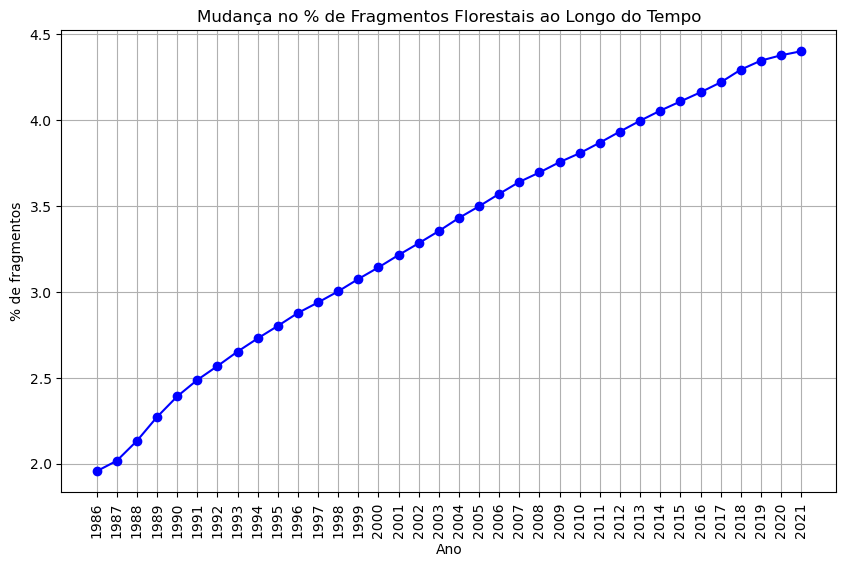

Anos com aumento significativo do número de fragmentos: ['1987.tif', '1988.tif', '1989.tif', '1990.tif', '1991.tif', '1992.tif', '1993.tif', '1994.tif', '1995.tif', '1996.tif', '1997.tif', '1998.tif', '1999.tif', '2000.tif', '2001.tif', '2002.tif', '2003.tif', '2004.tif', '2005.tif', '2006.tif', '2007.tif', '2008.tif', '2009.tif', '2010.tif', '2011.tif', '2012.tif', '2013.tif', '2014.tif', '2015.tif', '2016.tif', '2017.tif', '2018.tif', '2019.tif', '2020.tif', '2021.tif']


In [41]:

# Análise e visualização das métricas ao longo do tempo
if fragmentation_metrics:
    years = sorted(fragmentation_metrics.keys())
    
    # Exemplo: Visualizar o número de fragmentos ao longo do tempo
    np_values = [fragmentation_metrics[year]["fragmentation_percentage"] for year in years]  # Número de fragmentos

    # Calcular a diferença no número de fragmentos entre anos consecutivos
    np_diff = [np_values[i] - np_values[i - 1] for i in range(1, len(np_values))]

    # Identificar os anos com aumento significativo (diferença positiva)
    significant_increase_years = [years[i + 1] for i in range(len(np_diff)) if np_diff[i] > 0]

    # Plotar o número de fragmentos ao longo dos anos
    plt.figure(figsize=(10, 6))
    # Remover a extensão '.tif' dos anos
    years = [year.split('.')[0] for year in years]    
    plt.plot(years, np_values, marker="o", linestyle="-", color="blue")
    plt.xlabel("Ano")
    plt.xticks(rotation=90)
    plt.ylabel("% de fragmentos")
    plt.title("Mudança no % de Fragmentos Florestais ao Longo do Tempo")
    plt.grid(True)
    plt.show()

    # Exibir os anos com aumento significativo
    print(f'Anos com aumento significativo do número de fragmentos: {significant_increase_years}')
else:
    print("Nenhuma métrica foi calculada. Verifique se as classes estão presentes nos dados.")


#### 2.5 Análise Espacial das Áreas Degradadas

Além das métricas quantitativas, foram geradas visualizações que destacam as áreas com aumento significativo na fragmentação florestal. Essas visualizações são cruciais para identificar as regiões mais vulneráveis à degradação.

Mapa de Aumento Significativo na Fragmentação:

Os mapas abaixo ilustram as áreas que experimentaram um aumento significativo na fragmentação entre dois períodos consecutivos, conforme identificado pelos métodos de análise de imagem.

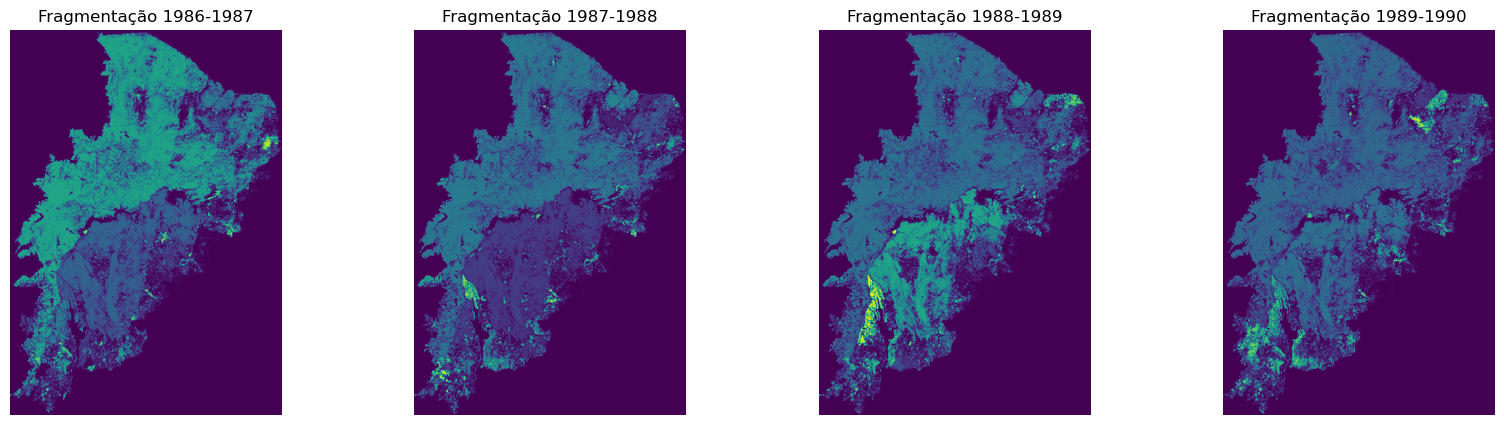

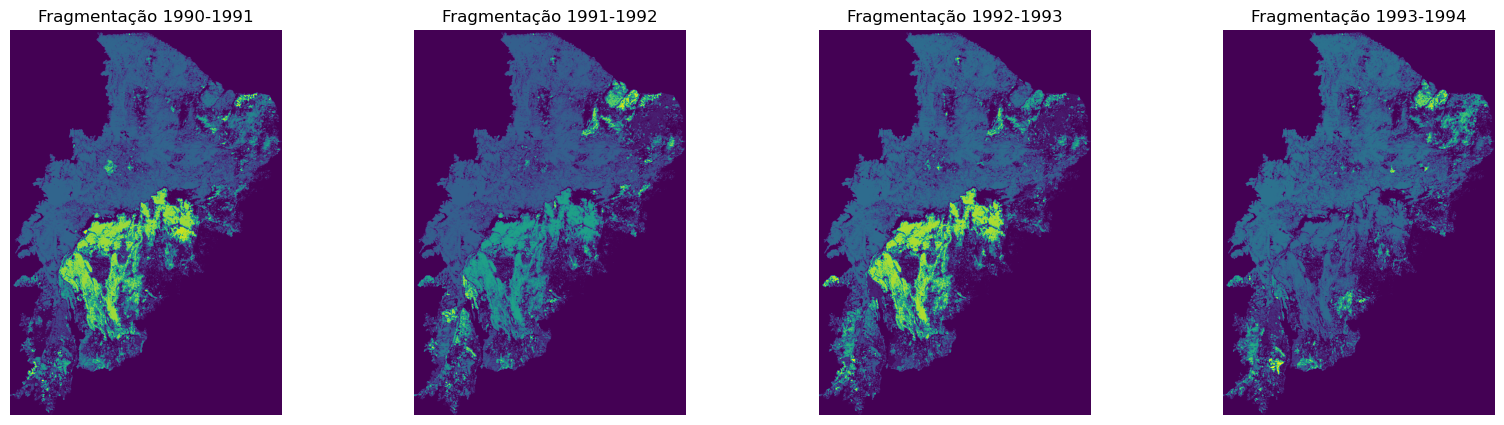

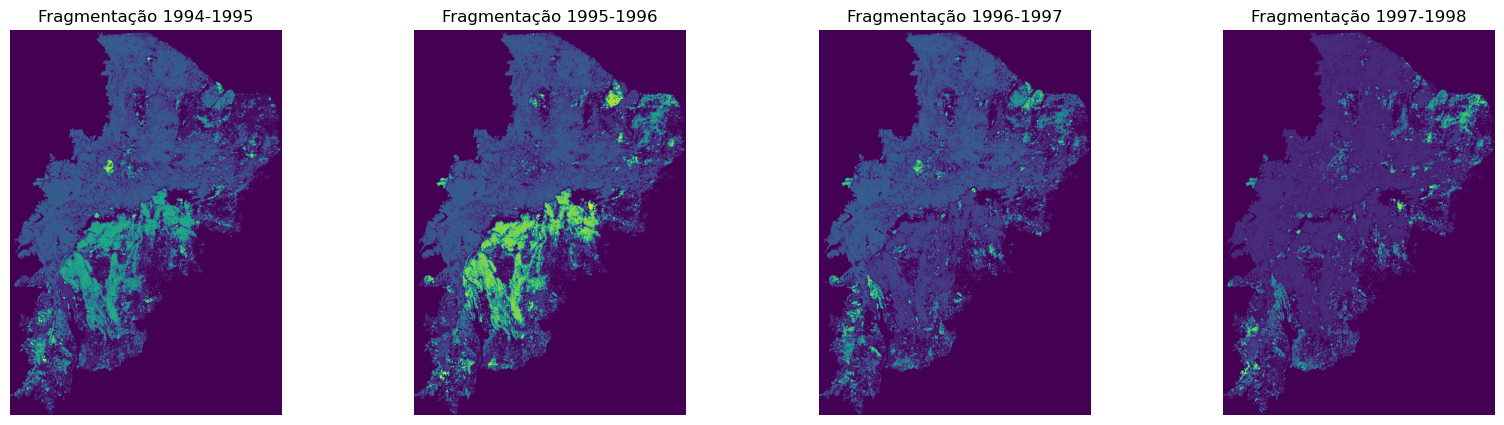

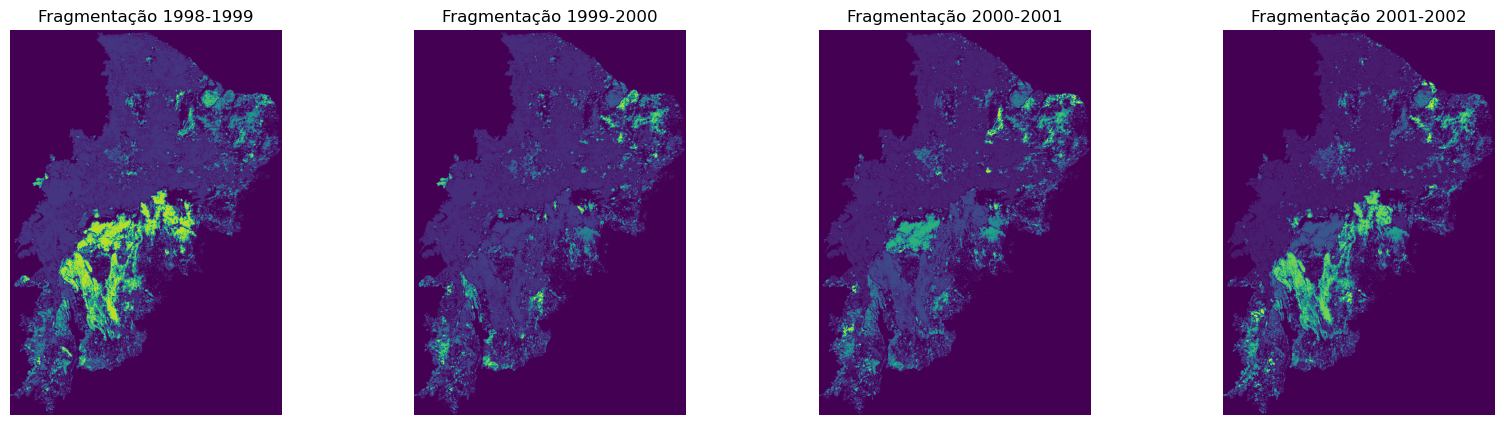

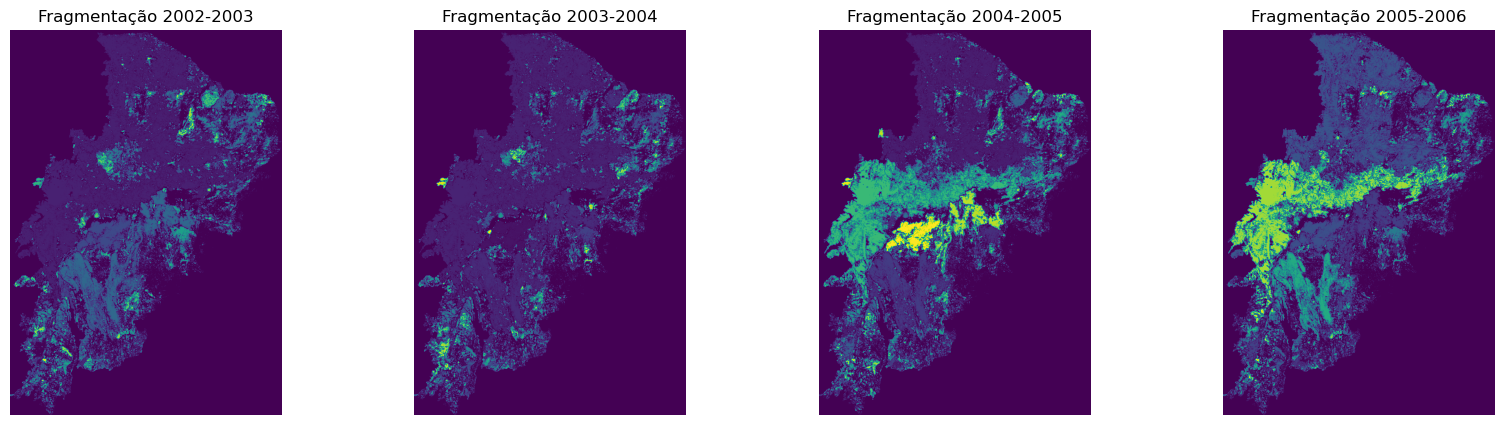

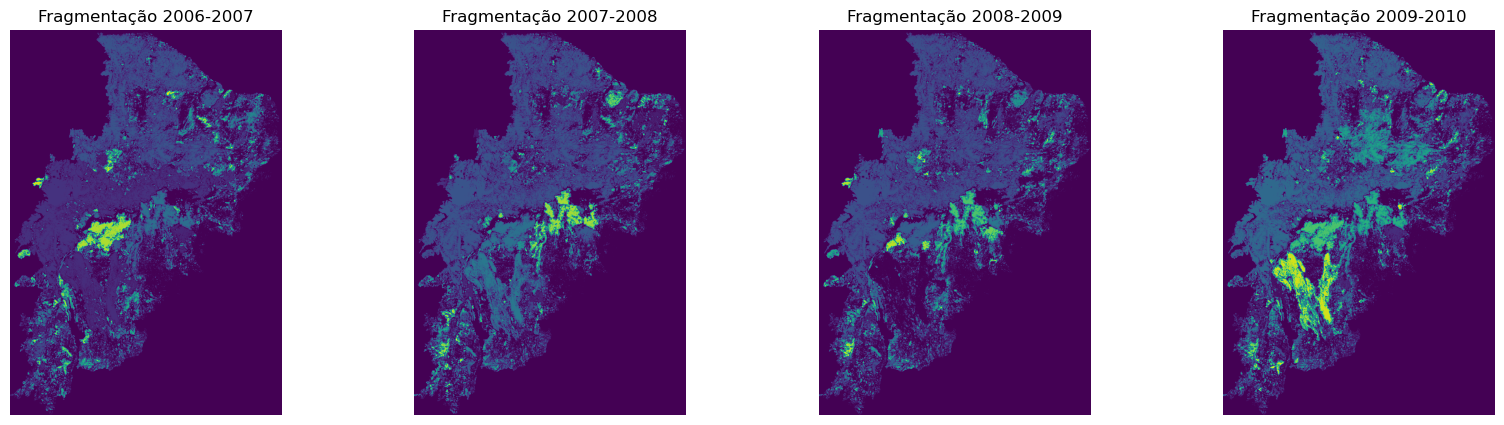

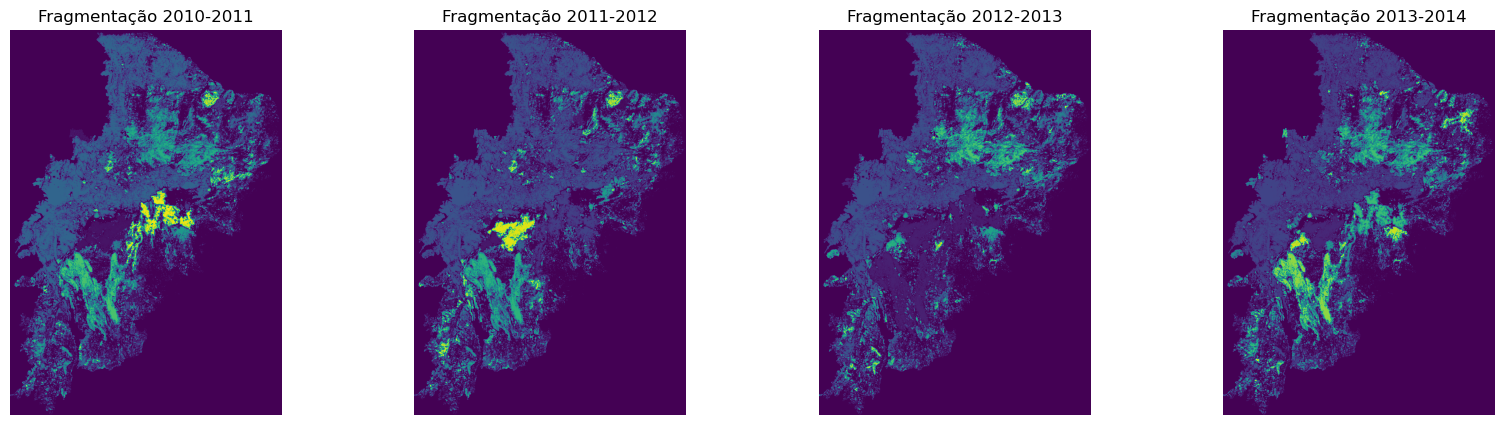

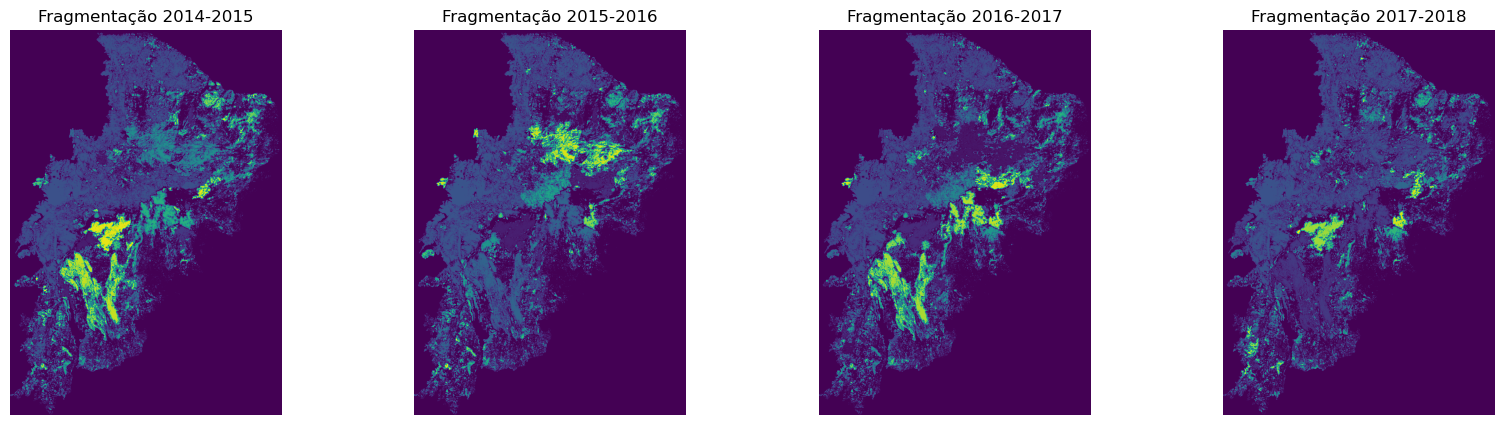

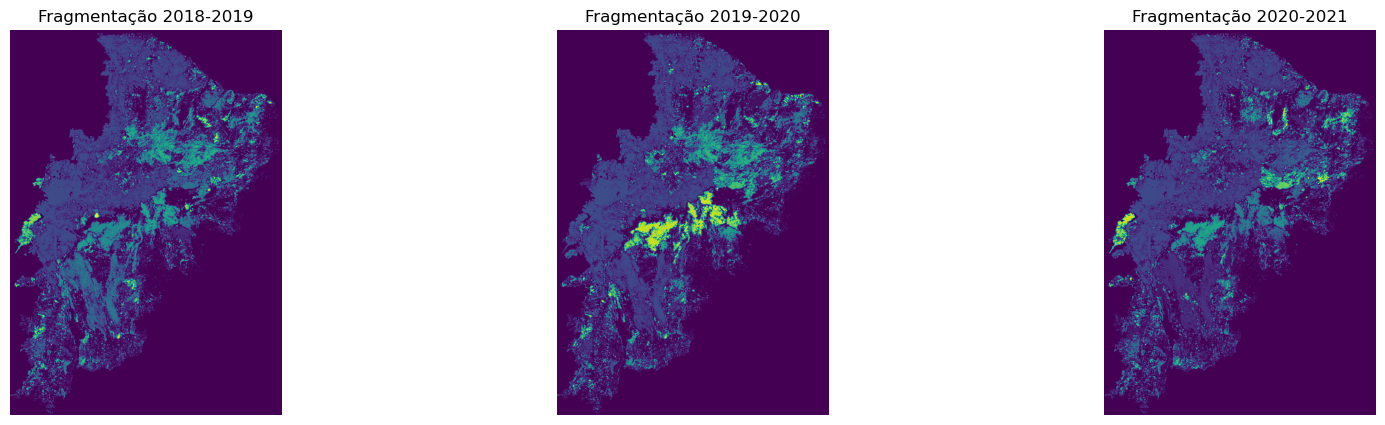

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import label
import logging

def display_images_side_by_side(images, titles):
    """Exibe uma lista de imagens lado a lado com títulos."""
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Definir o caminho da pasta contendo os arquivos raster
data_dir = './data/mapbiomas'
output_dir = './data/mapbiomas/fragmentacao'

# Criar a pasta de saída se não existir
os.makedirs(output_dir, exist_ok=True)

# Configurar o logger
log_file = os.path.join(output_dir, 'fragmentation_log.txt')
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Listar todos os arquivos na pasta com a extensão .tif e ordená-los
file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.tif')])

# Verificar se há pelo menos dois arquivos para análise
if len(file_names) < 2:
    raise ValueError("A pasta deve conter pelo menos dois arquivos GeoTIFF para a análise.")

# Definir a classe de interesse, por exemplo, classe 73 (floresta)
class_value = 73

# Lista para acumular imagens e títulos
images = []
titles = []

# Iterar sobre os arquivos dois a dois, garantindo que os anos sejam diferentes
for i in range(len(file_names) - 1):
    # Obter os caminhos completos dos arquivos para os anos consecutivos
    file_prev = os.path.join(data_dir, file_names[i])
    file_next = os.path.join(data_dir, file_names[i + 1])

    # Extrair os anos dos nomes dos arquivos
    year_prev = file_names[i].split('_')[1][:4]
    year_next = file_names[i + 1].split('_')[1][:4]

    # Verificar se os anos são diferentes
    if year_prev == year_next:
        continue

    # Carregar os mapas dos dois anos consecutivos
    with rasterio.open(file_prev) as src_prev, rasterio.open(file_next) as src_next:
        raster_prev = src_prev.read(1)
        raster_next = src_next.read(1)

    # Criar máscaras binárias para a classe de interesse
    mask_prev = (raster_prev == class_value)
    mask_next = (raster_next == class_value)

    # Contar o número de fragmentos (patches) usando a função label
    labeled_prev, num_patches_prev = label(mask_prev)
    labeled_next, num_patches_next = label(mask_next)

    # Calcular a área total para cada ano (em pixels)
    total_area_prev = np.sum(mask_prev)
    total_area_next = np.sum(mask_next)

    # Registrar as métricas principais para cada ano
    logger.info(f"Métricas de Fragmentação {year_prev}:")
    logger.info(f"Número de fragmentos: {num_patches_prev}, Área total: {total_area_prev} pixels")

    logger.info(f"Métricas de Fragmentação {year_next}:")
    logger.info(f"Número de fragmentos: {num_patches_next}, Área total: {total_area_next} pixels")

    # Calcular a Diferença de Fragmentação
    diff_patches = num_patches_next - num_patches_prev
    logger.info(f"Diferença no número de fragmentos ({year_next} - {year_prev}): {diff_patches}")

    # Criar uma Máscara para Identificar Áreas com Aumento de Fragmentação
    significant_increase_mask = (labeled_next > 0) & (labeled_prev == 0)

    # Filtrar as áreas com aumento significativo de fragmentação
    significant_increase_areas = np.zeros_like(raster_next)
    significant_increase_areas[significant_increase_mask] = labeled_next[significant_increase_mask]

    # Verificar se a máscara está funcionando corretamente (se há fragmentos identificados)
    logger.info(f"Áreas identificadas com aumento significativo em {year_next}: {np.sum(significant_increase_mask)} pixels")

    # Adicionar a imagem e o título à lista
    images.append(significant_increase_areas)
    titles.append(f'Fragmentação {year_prev}-{year_next}')

    # Salvar a imagem gerada na pasta de saída
    output_file = os.path.join(output_dir, f'fragmentacao_{year_prev}_{year_next}.png')
    plt.imsave(output_file, significant_increase_areas, cmap='viridis')
    logger.info(f'Imagem salva em: {output_file}')

    # Exibir imagens lado a lado a cada 4 imagens
    if len(images) == 4:
        display_images_side_by_side(images, titles)
        images = []
        titles = []

# Exibir as imagens restantes (menos de 4)
if images:
    display_images_side_by_side(images, titles)


Interpretação: As áreas em destaque (em tons mais claros) indicam regiões onde houve um aumento significativo na fragmentação florestal. Estas áreas são prioritárias para intervenções de conservação e reflorestamento.

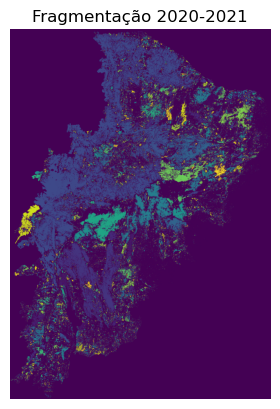

In [43]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def create_animation(image_folder, output_file):
    """Cria uma animação a partir das imagens geradas."""
    # Listar todos os arquivos de imagem na pasta e ordená-los
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    # Carregar as imagens
    images = [plt.imread(os.path.join(image_folder, img)) for img in image_files]

    # Criar a figura e o eixo
    fig, ax = plt.subplots()

    # Função de atualização para a animação
    def update(frame):
        ax.clear()
        ax.imshow(images[frame], cmap='viridis')
        ax.set_title(f'Fragmentação {image_files[frame].split("_")[1]}-{image_files[frame].split("_")[2].split(".")[0]}')
        ax.axis('off')

    # Criar a animação
    ani = animation.FuncAnimation(fig, update, frames=len(images), repeat=True)

    # Salvar a animação como um arquivo de vídeo
    ani.save(output_file, writer='imagemagick', fps=1)

    # Exibir a animação no Jupyter Notebook
    plt.show()

# Definir a pasta de imagens e o arquivo de saída
image_folder = './data/mapbiomas/fragmentacao'
output_file = './data/mapbiomas/fragmentacao/fragmentacao_animation.gif'

# Criar a animação
create_animation(image_folder, output_file)


## 3. Discussão

Nesta seção, discutimos as implicações dos resultados obtidos no estudo da degradação florestal na Caatinga utilizando imagens de satélite e análise de sensoriamento remoto. Os principais aspectos discutidos incluem a evolução temporal do NDVI, as mudanças na fragmentação florestal, a eficiência das metodologias aplicadas e as possíveis implicações ecológicas e de conservação.

### 3.1 Evolução Temporal do NDVI

A análise temporal do NDVI revelou padrões importantes na dinâmica da vegetação na Caatinga ao longo dos anos. O NDVI, que é um indicador amplamente utilizado da biomassa vegetal e da saúde da vegetação, apresentou variações sazonais claras, com picos associados aos períodos de maior precipitação e declínios durante as secas.

**Interpretação dos Resultados:**

- **Variação Sazonal:** O padrão de variação sazonal do NDVI é consistente com o ciclo natural da Caatinga, um bioma semiárido onde a vegetação responde diretamente à disponibilidade de água. Durante a estação chuvosa, o NDVI aumenta, refletindo a rebrota da vegetação. Durante a estação seca, o NDVI diminui, indicando uma queda na cobertura vegetal.
- **Tendências ao Longo do Tempo:** Embora o padrão sazonal seja evidente, uma análise mais aprofundada sugere uma tendência de declínio no NDVI ao longo dos anos, especialmente em áreas específicas. Isso pode ser um indicativo de degradação progressiva da vegetação devido a fatores como desmatamento, mudanças no uso da terra e impactos climáticos.

**Implicações:**

- **Degradação Ambiental:** A tendência de declínio do NDVI em certas áreas pode estar associada à degradação ambiental, possivelmente exacerbada por atividades humanas como agricultura intensiva, extração de madeira e pastoreio excessivo. 
- **Monitoramento Contínuo:** A continuidade deste monitoramento é essencial para entender as mudanças a longo prazo e para orientar políticas de conservação.

### 3.2 Fragmentação Florestal

Os resultados da análise de fragmentação florestal mostraram um aumento significativo no número de fragmentos de vegetação ao longo do período de estudo, especialmente entre 1986 e 2021. As métricas de fragmentação, como o Número de Fragmentos (NP) e a Densidade de Borda (ED), indicam uma crescente fragmentação das áreas de vegetação, o que pode ter sérias implicações para a biodiversidade e a funcionalidade dos ecossistemas.

**Interpretação dos Resultados:**

- **Aumento da Fragmentação:** O aumento no número de fragmentos e na densidade de borda sugere que as áreas de vegetação contínua estão sendo cada vez mais divididas em fragmentos menores, o que pode resultar em habitats menos conectados e mais vulneráveis à degradação.
- **Impactos na Biodiversidade:** A fragmentação florestal é conhecida por reduzir a biodiversidade, pois isola populações de espécies, limita o fluxo genético e aumenta a vulnerabilidade a invasões de espécies exóticas e a mudanças climáticas.

**Implicações:**

- **Conectividade Ecológica:** A perda de conectividade ecológica devido à fragmentação pode comprometer a resiliência dos ecossistemas da Caatinga, tornando-os menos capazes de se adaptar a mudanças ambientais.
- **Prioridades de Conservação:** As áreas identificadas como altamente fragmentadas devem ser priorizadas para intervenções de conservação, como corredores ecológicos e projetos de restauração florestal.

### 3.3 Eficiência das Metodologias Aplicadas

O uso do Google Earth Engine (GEE) combinado com ferramentas de análise espacial como o Fragstat provou ser uma abordagem eficaz para o monitoramento da degradação florestal. A metodologia permitiu a aquisição e processamento de grandes volumes de dados de satélite de forma eficiente, além de fornecer uma base robusta para a análise temporal e espacial.

**Pontos Fortes:**

- **Escalabilidade:** A capacidade do GEE de processar grandes volumes de dados em escala global foi um fator crucial para a realização deste estudo, permitindo análises que seriam inviáveis em plataformas convencionais.
- **Precisão:** O uso de métricas de fragmentação e o cálculo do NDVI proporcionaram uma visão detalhada das mudanças na vegetação e na estrutura florestal da Caatinga.

**Limitações:**

- **Resolução Espacial:** Embora as imagens de satélite forneçam uma visão abrangente, a resolução espacial pode limitar a detecção de mudanças em áreas muito pequenas ou em mosaicos de vegetação complexos.
- **Cobertura Nuvosa:** A presença de nuvens, apesar de mitigada por máscaras de nuvens e filtragens, ainda pode introduzir incertezas em algumas análises temporais, especialmente em períodos de alta nebulosidade.

**Implicações:**

- **Aperfeiçoamento das Técnicas:** Há espaço para melhorar a metodologia, talvez incorporando dados de sensoriamento remoto com resoluções temporais e espaciais mais finas, como dados de drones ou de sensores mais recentes.
- **Relevância para Políticas Públicas:** Os resultados robustos e precisos obtidos através desta metodologia são de extrema relevância para informar políticas públicas e estratégias de conservação na Caatinga.

### 3.4 Implicações Ecológicas e de Conservação

Os resultados deste estudo têm implicações diretas para a conservação da Caatinga. A degradação da vegetação e o aumento da fragmentação florestal são preocupantes e exigem atenção urgente de órgãos governamentais, ONGs e comunidades locais.

**Desafios Ecológicos:**

- **Perda de Habitats:** A fragmentação leva à perda de habitats essenciais para muitas espécies endêmicas da Caatinga, colocando em risco a biodiversidade local.
- **Mudanças Climáticas:** A degradação florestal pode agravar os efeitos das mudanças climáticas, tornando a região mais suscetível a secas prolongadas e a outros fenômenos extremos.

**Recomendações para Conservação:**

- **Restauro Ecológico:** Projetos de restauração ecológica devem ser implementados nas áreas mais degradadas para recuperar a vegetação nativa e melhorar a conectividade entre fragmentos florestais.
- **Monitoramento Contínuo:** Deve-se manter o monitoramento contínuo da vegetação utilizando tecnologias de sensoriamento remoto para detectar mudanças precoces e planejar ações de mitigação.
- **Educação Ambiental:** A conscientização e o envolvimento das comunidades locais são fundamentais para a implementação bem-sucedida de estratégias de conservação e para garantir a sustentabilidade das práticas de uso da terra.

### 3.5 Considerações Finais

Este estudo fornece evidências claras da degradação florestal na Caatinga e da necessidade de ações imediatas para mitigar seus impactos. As metodologias aplicadas demonstraram ser eficazes na detecção de mudanças na cobertura vegetal e na estrutura florestal, oferecendo uma base sólida para futuras pesquisas e intervenções de conservação.

## Conclusão

- **Urgência nas Ações:** As tendências observadas apontam para a necessidade urgente de políticas de conservação que abordem a fragmentação florestal e a degradação da vegetação, visando a proteção da biodiversidade e a manutenção dos serviços ecossistêmicos da Caatinga.
- **Próximos Passos:** Estudos futuros devem focar em integrar dados adicionais, como modelos climáticos, e explorar novas tecnologias de sensoriamento remoto para aprimorar o monitoramento e a análise da degradação florestal.

*Necessita de revisões* (2024)